<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/Scratch_CNN_masses_vs_calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scratch CNN**
---
Classification model for discriminating between 2 classes: **masses and calcification**. *Ad-hoc CNN architecture*.

**Students:**   *A. Schiavo - M. Gómez - M. Daole*

## Data Loading
This can be easily done with the Python data manipulation. Modern deep learning provides a very powerful framework for supervised learning, we introduce on this step the convolutional network for scaling to large images.


In [51]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [101]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model

BATCH_SIZE = 20
EPOCHS = 100

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"
train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

MODEL_PATH = os.path.join(base_path, "models")

print("Done")

Done


In [100]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


In [97]:
# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # Calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

Done


In [106]:
# Visualization Confusion Matrix
def plot_confusion_matrix(classes, # Array with the classes name
                          datagen,
                          dataset, 
                          labels,
                          batch_size=BATCH_SIZE,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    """
    predicted = model.predict(datagen.flow(dataset,
                                            labels,
                                            batch_size=batch_size,
                                            shuffle=False),
                          steps=len(dataset) // batch_size)

    prediction = np.where(predicted < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, prediction)

    print(classification_report(labels, prediction))

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Visualization Data Histogram
def plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt

print("Done")

Done


In [28]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


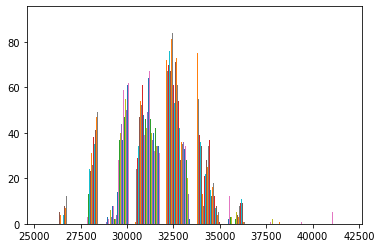

In [29]:
# Check the value range and the distribution
plt.hist(train_images[0]) 
plt.show()

In [30]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150, 1)
Test shape:  (336, 150, 150, 1)


In [10]:
# Verify values range: 
# Getting max value 
max = max([np.max(image) for image in train_images]) # max is 65535 

# Getting min value
min = min([np.min(image) for image in train_images]) # min is 0

print("Original tensor are of type ", train_images[0].dtype, " with values in the range [", min,",", max, "]")

Original tensor are of type  uint16  with values in the range [ 0 , 65535 ]


## Data preprocessing

Computer vision usually requires relatively little of this kind of preprocessing. The images should be standardized, formatting images to have the same scale is the only kind of preprocessing that is strictly necessary. As optional, we add dataset augmentation because is an excellent way to reduce the generalization error of most computer vision models.

In [11]:
# Split dataset into training and validation set 70-30
train_images_split = train_images[:int(0.7*len(train_images))]
valid_images_split = train_images[int(0.7*len(train_images)):]
train_labels_split = train_labels[:int(0.7*len(train_labels))]
valid_labels_split = train_labels[int(0.7*len(train_labels)):]

print(train_images_split.shape)
print(valid_images_split.shape)                                       

(1873, 150, 150, 1)
(803, 150, 150, 1)


In [12]:
# All images will be rescaled by 1./65535 (max value range)
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

for batch, labels_batch in train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE):
  print(batch.shape)
  print(labels_batch.shape)
  break

(20, 150, 150, 1)
(20,)


### Defining CNN 


In [53]:
def build_model(loss_function, eval_metric=["acc"]):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  #model.add(layers.Dense(512, activation='relu'))
  #model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-4), # lr = 0.0001
              metrics=eval_metric) 
  
  return model 

print("Done")

Done


### CNN Compilation



In [62]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
]

model = build_model("binary_crossentropy", METRICS)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 128)      

In [63]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])

Epoch 1/100
93/93 [==============================] - 6s 47ms/step - loss: 1.4287 - acc: 0.5295 - precision: 0.5333 - recall: 0.9372 - auc: 0.4576 - val_loss: 1.0298 - val_acc: 0.5500 - val_precision: 0.5500 - val_recall: 1.0000 - val_auc: 0.7518
Epoch 2/100
93/93 [==============================] - 4s 42ms/step - loss: 0.9548 - acc: 0.5447 - precision: 0.5439 - recall: 0.9524 - auc: 0.5462 - val_loss: 0.7822 - val_acc: 0.5500 - val_precision: 0.5500 - val_recall: 1.0000 - val_auc: 0.8162
Epoch 3/100
93/93 [==============================] - 4s 41ms/step - loss: 0.7639 - acc: 0.5658 - precision: 0.5598 - recall: 0.9096 - auc: 0.5864 - val_loss: 0.6969 - val_acc: 0.6375 - val_precision: 0.6084 - val_recall: 0.9568 - val_auc: 0.8227
Epoch 4/100
93/93 [==============================] - 4s 41ms/step - loss: 0.7073 - acc: 0.6194 - precision: 0.6096 - recall: 0.8265 - auc: 0.6389 - val_loss: 0.6659 - val_acc: 0.7075 - val_precision: 0.9478 - val_recall: 0.4955 - val_auc: 0.8227
Epoch 5/100
93/9

In [64]:
# Save Model to drive
models.save_model(model, os.path.join(MODEL_PATH, 'cnn_compilation.h5'))

print("Done")

Done


### Visualizing The Data

One way to do this is by looking at the distribution of some of the dataset’s variables and make scatter plots to see possible correlations. 

In [21]:
# For the visualization of the data
# Load and use the previous model
model = load_model(os.path.join(MODEL_PATH, 'cnn_compilation.h5'))

print("Done")

Done


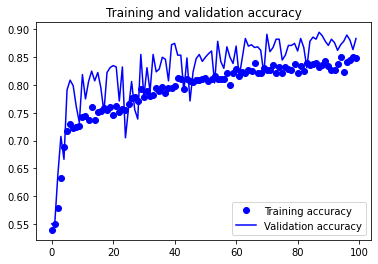

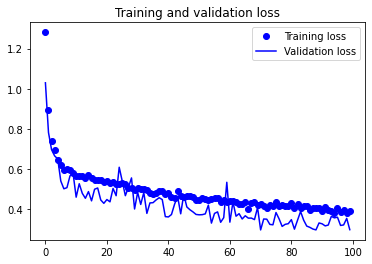

In [88]:
plt = plot(history)
plt.show()

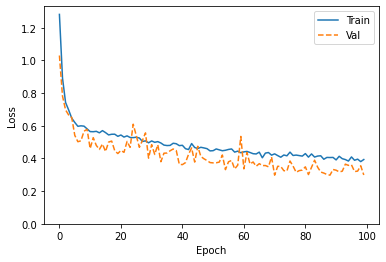

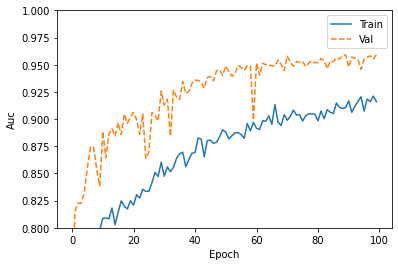

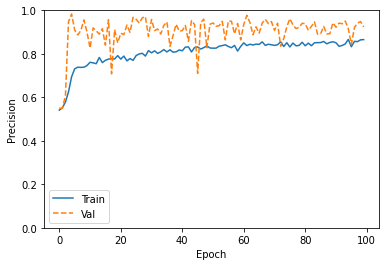

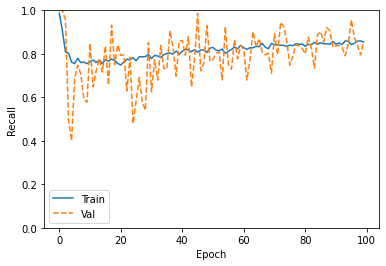

In [98]:
plt = plot_metrics(history)
plt.show()

In [104]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE,
                                     callbacks=[GarbageCollectorCallback()])
print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_acc*100), "%")
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % (test_auc*100), "%")
print("---------------------------------\n")


16/16 [==============================] - 0s 7ms/step - loss: 0.3557 - acc: 0.8531 - precision: 0.8615 - recall: 0.7943 - auc: 0.9355    

---------------------------------
Accuracy: 85.31 %
Precision: 86.15 %
Recall: 79.43 %
AUC: 93.55 %
---------------------------------



(336, 150, 150, 1) (336,)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.87       179
         1.0       0.87      0.80      0.83       157

    accuracy                           0.85       336
   macro avg       0.85      0.85      0.85       336
weighted avg       0.85      0.85      0.85       336



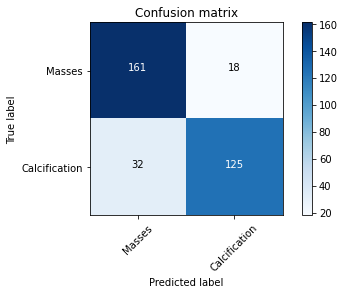

In [107]:
# Print confusion matrix
classes = ["Masses", "Calcification"]
batch_size = 16
print(test_images.shape, test_labels.shape)
plot_confusion_matrix(classes, test_datagen, test_images, test_labels, batch_size)

### Fighting overfitting: 1. Data Augmentation

Neural networks prove not to be very robust to noise, and these plots are characteristic of **overfitting**. Training accuracy keeps increasing linearly while validation accuracy stalls around **82%**. 



In [31]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


In [32]:
# Building the new model with the train data augmentation
model = build_model("binary_crossentropy", "acc")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])

In [33]:
# Save Model to drive
models.save_model(model, os.path.join(MODEL_PATH, 'cnn_augmentation.h5'))

print("Done")

Done


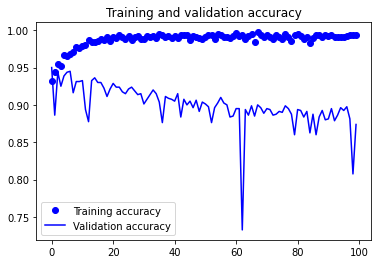

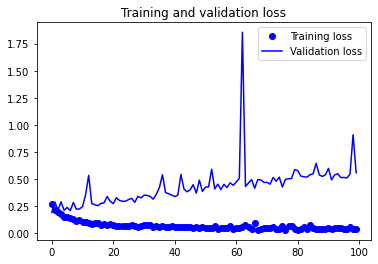

In [44]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE,
                                     callbacks=[GarbageCollectorCallback()])

print("Accuracy:", "%0.2f" % (test_acc*100), "%")

##K-fold cross validation.


In [ ]:
# Train data augmentation for k-fold-cross-validation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
print(train_images.shape)

In [ ]:
def cross_validate(k, batch_size, num_epochs, dataset, targets, verbosity):
  #10-Fold-Cross-Validation
  num_val_samples = len(dataset) // k 
  validation_accuracies = []
  validation_losses = []

  for i in range(k):
    # rigen augmented data 
    
    print("processing fold #", i)
    validation_data = dataset[i * num_val_samples : (i + 1) * num_val_samples]
    validation_labels = targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [dataset[:i * num_val_samples],
        dataset[(i + 1) * num_val_samples:]], 
        axis=0)

    partial_train_targets = np.concatenate(
        [targets[:i * num_val_samples],
        targets[(i + 1) * num_val_samples:]], 
        axis=0)

    model = build_model("binary_crossentropy", "acc")
    
    history = model.fit(train_datagen.flow(partial_train_data, 
                                          partial_train_targets,
                                          batch_size=batch_size,
                                          shuffle=False),
                        epochs=num_epochs,
                        steps_per_epoch=len(partial_train_data) // batch_size,
                        verbose=verbosity,
                        callbacks=[GarbageCollectorCallback()])
    
    val_loss, val_acc = model.evaluate(valid_datagen.flow(validation_data,
                                                          validation_labels,
                                                          batch_size=batch_size,
                                                          shuffle=False),
                                       steps=len(validation_data) // batch_size,
                                       callbacks=[GarbageCollectorCallback()])
    
    validation_accuracies.append(val_acc)
    validation_losses.append(val_loss)

  return validation_accuracies, validation_losses 
  
print("Done")

In [ ]:
acc, loss = cross_validate(k=10, batch_size=20, num_epochs=100, dataset=train_images, targets=train_labels, verbosity=1)

In [ ]:
print(len(acc))
print(len(loss))
print()
print(np.mean(acc))
print(np.mean(loss))

### Hyperparameters Tuning

To compare the performance of one machine learning algorithm to another, it is necessary to perform controlled experiments

*   Add Dropout or L2 Regularization
*   Varying of convolutional layers: `[3, 5, 7]`
*   Change Optimizer (try Adam)
*   Varying batch size: `[20, 32, 64, 128]`
*   Varying learning rate
*   Varying number of units per layer:

```
Layer  | Unit per Layer 
1      | [32,32,64,128]  
2      | [32,64,128,128] 
3      | [32,64,128,256] 
4      | [64,64,128,256] 
```

In [ ]:
#Parameters Grid 
dropout_regularization = True                                               # grafico comparativo: sembra leggermente meglio con Dropout
batch_sizes = [20, 32, 64, 128]                                             # 4 
layers_number = 4                                                           # 1
units_per_layer_dict = [[32,64,128,128], [32,64,128,256]]                   # 2
learning_rates = [1e-2, 1e-3, 1e-4]                                         # 3
num_epochs = 100
num_folds = 5

file_path_out = os.path.join(base_path, "tuning results/top3_results.csv")
file_path = os.path.join(base_path, "tuning results/results-CM.csv")
model_path = os.path.join(base_path, "tuning results/best_model.h5")

# Top k models 
k = 3

In [ ]:
def build_custom_model(layers_number, units_per_layer, batch_size, dropout, optimizer):
  model = models.Sequential()

  for i in range(layers_number):
     # First layer. Setting input shape
    if i == 0: 
      model.add(layers.Conv2D(units_per_layer[i], (3, 3), activation='relu', input_shape=(150, 150, 1)))
      model.add(layers.MaxPooling2D((2, 2)))
    else:
      model.add(layers.Conv2D(units_per_layer[i], (3, 3), activation='relu'))
      model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  
  if dropout:
    model.add(layers.Dropout(0.5))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["acc"]) 
  
  return model 

def CNN_tuning(num_folds, batch_sizes, num_epochs, layers_number, units_per_layer_dict, learning_rates, dropout_reg, dataset, targets):
  lr = learning_rates[0]
  opts = [optimizers.RMSprop(learning_rate=lr), optimizers.Adam(learning_rate=lr)]

  with open(file_path, 'w') as f:
    header = "batch_size,num_epochs,units_per_layer,optimizer,learning_rate,mean_val_acc,mean_val_loss,num_folds\n"
    f.write(header)

  for batch_size in batch_sizes:                # 4
    for opt in opts:                            # 2
      for values_set in units_per_layer_dict:   # 2
        # Build CNN model 
        model = build_custom_model(layers_number, values_set, batch_size, dropout_reg, opt)

        if "RMSprop" in str(opt):
          str_opt = "RMSprop"  
        else:
          str_opt = "Adam"

        #print info 
        print("-----------------------------------------------------")
        print("batch_size: \t", batch_size)
        print("num_epochs: \t", num_epochs)
        print("units_per_layer:", str(values_set).replace(",", " "))
        print("optimizer: \t", str_opt)
        print("learning_rate: \t", str(lr))
        print("num_folds CV: \t", num_folds)
        print("-----------------------------------------------------")

        #cross validate CNN model
        val_acc, val_loss = cross_validate(num_folds, batch_size, num_epochs, dataset, targets, 1)

        #save results on csv file 
        with open(file_path, 'a') as f:
          row = str(batch_size) + "," \
              + str(num_epochs) + "," \
              + str(values_set).replace(",", " ") + "," \
              + str_opt + "," \
              + str(lr) + "," \
              + "%0.4f (+/- %0.4f)" % (np.mean(val_acc), np.std(val_acc) * 2) + "," \
              + "%0.4f (+/- %0.4f)" % (np.mean(val_loss), np.std(val_loss) * 2) + "," \
              + str(num_folds) + "\n"
          f.write(row)

        del model
        K.clear_session()

print("Done")

In [ ]:
CNN_tuning(num_folds, batch_sizes, num_epochs, layers_number, units_per_layer_dict, learning_rates, dropout_regularization, train_images, train_labels)

##Testing best k models: 
feeding the models with all available data and evaluating these one last time on the test set.

In [ ]:
# Full training set non-splitted 
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

In [ ]:
def evaluate_best_model(k, file_path, file_path_out):
  # Load results  
  data = pd.read_csv(file_path)

  # Sort results by accuracies 
  data.sort_values(by=['mean_val_acc'], ascending=False, inplace=True)
  data.head()

  # Init variables
  layers_number = 4
  batch_size = 0
  num_epochs = 0
  units_per_layer = []
  optimizer = 0
  learning_rate = 0
  dropout=True

  with open(file_path_out, 'w') as f:
    header = "batch_size,num_epochs,units_per_layer,optimizer,learning_rate,mean_val_acc,mean_val_loss,prediction_acc\n"
    f.write(header)

  # Get parameters values
  for index, row in data[:k].iterrows():

    #print info 
    print("-----------------------------------------------------")
    print("batch_size: \t", str(row["batch_size"]))
    print("num_epochs: \t", str(row["num_epochs"]))
    print("units_per_layer:", str(row["units_per_layer"]))
    print("optimizer: \t", str(row["optimizer"]))
    print("learning_rate: \t", str(row["learning_rate"]))
    print("mean_val_acc: \t", str(row["mean_val_acc"]))
    print("mean_val_loss: \t", str(row["mean_val_loss"]))
    print("-----------------------------------------------------")


    batch_size = int(row["batch_size"])
    num_epochs = int(row["num_epochs"])
    units_per_layer = ast.literal_eval(row["units_per_layer"].replace("  ", ","))
    optimizer = row["optimizer"]
    learning_rate = row["learning_rate"]

    if optimizer == "Adam":
      opt = optimizers.Adam(learning_rate=float(learning_rate))
    else: 
      opt = optimizers.RMSprop(learning_rate=float(learning_rate))

    # Build model
    model = build_custom_model(layers_number, units_per_layer, batch_size, dropout, opt)

    # Fit model on all the available data
    history = model.fit(train_datagen.flow(train_images, 
                                          train_labels,
                                          batch_size=batch_size,
                                          shuffle=False),
                        epochs=num_epochs,
                        steps_per_epoch=len(train_images) // batch_size,
                        callbacks=[GarbageCollectorCallback()])
    
    # Evaluate model on test set 
    test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                        test_labels,
                                                        batch_size=batch_size,
                                                        shuffle=False),
                                        steps=len(test_images) // batch_size,
                                        callbacks=[GarbageCollectorCallback()])

    print("Accuracy:", "%0.2f" % (test_acc*100), "%")

    # Get the prediction for each sample
    predictions = model.predict(
      test_images,
      max_queue_size=10,
      callbacks=[GarbageCollectorCallback()]) 
    
    predicted = np.argmax(predictions,axis=1) 

    correct_predictions = np.sum(np.equal(predicted,test_labels))
    accuracy = correct_predictions/len(test_labels)
    print("\n-----------------------------------------------------")
    print("Correct Predictions")
    print("Accuracy:", "%0.2f" % (accuracy*100), "%")
    print("-----------------------------------------------------\n")

    if index == 0:
      model.save(model_path)

    # Save results on csv file 
    with open(file_path_out, 'a') as f:
      row = str(row["batch_size"]) + "," \
          + str(row["num_epochs"]) + "," \
          + str(row["units_per_layer"]) + "," \
          + str(row["optimizer"]) + "," \
          + str(row["learning_rate"]) + "," \
          + str("%0.4f" % (test_acc)) + "," \
          + str("%0.4f" % (test_loss)) + "," \
          + str(accuracy) + "\n"
      f.write(row)

print("Done")

Done


In [ ]:
data[:k].head()

In [ ]:
# Get from file the a list of models and evaluate the best
evaluate_best_model(k, file_path, file_path_out)

In [ ]:
# Get the prediction for each sample
model = load_model(model_path)


In [ ]:

predictions = model.predict(
  test_images,
  max_queue_size=10,
  callbacks=[GarbageCollectorCallback()]) 

predicted = np.argmax(predictions,axis=1) 

correct_predictions = np.sum(np.equal(predicted,test_labels))
accuracy = correct_predictions/len(test_labels)


# try to load the model again

test_loss, test_acc = model.evaluate(test_images,test_labels)

print('test_acc:', test_acc)

In [ ]:
a = [0.111,0.222,1.222]
print(a)

In [ ]:
a = a.astype(int)

np.clip(a, 0, 1)

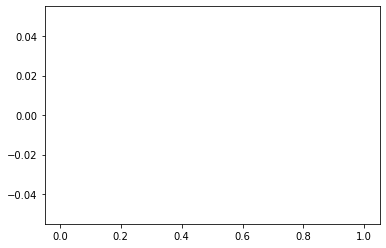

[0. 1.] [179 157]


In [ ]:
number_list = np.array([1, 1, 3, 3, 2, 3, 4, 4, 1])

(unique, counts) = np.unique(test_labels, return_counts=True)

plt.hist(counts, unique) 
plt.show()
print(unique, counts)

In [ ]:
#print confusion matrix
classes = ["Masses", "Calcification"]
plot_confusion_matrix(classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues) 

## Reference


>**Student** | **Email contact**
>--- | ---
>A. Schiavo | a.schiavo2@studenti.unipi.it
>M. Gómez	|	m.gomezgomez@studenti.unipi.it
>M. Daole |	m.daole@studenti.unipi.it
